In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics

import shared_utils
import branca
from utils import *

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Get and transform test data (Long Beach Transit, 170)

In [2]:
lbt_itp_id = 170

In [3]:
# %%sql -o lbt_positions

# # get all vehicle positions on selected dates, for the feed with itp id 170, and url number 0
# SELECT *
# FROM `cal-itp-data-infra.gtfs_rt.vehicle_positions`
# WHERE _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-01_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-02_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-03_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-04_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-05_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-06_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-07_170_0.parquet"
# ORDER BY header_timestamp

In [4]:
# lbt_positions.to_parquet(f'{GCS_FILE_PATH}lbt_positions.parquet')

In [5]:
lbt_positions = pd.read_parquet(f'{GCS_FILE_PATH}lbt_positions.parquet')

#### Reformat timestamps

In [6]:
## set system time
os.environ['TZ'] = 'America/Los_Angeles'
time.tzset()
time.tzname

('PST', 'PDT')

In [7]:
def convert_ts(ts):    
    pacific_dt = dt.datetime.fromtimestamp(ts)
    # print(pacific_dt)
    return pacific_dt

In [8]:
lbt_positions.vehicle_timestamp = lbt_positions.vehicle_timestamp.apply(convert_ts)
lbt_positions.header_timestamp = lbt_positions.header_timestamp.apply(convert_ts)

In [9]:
# min_date, max_date = ('2021-11-01', '2021-12-01')
pch_routes = ('171', '172', '173', '174', '175')

# lbt_trips = (tbl.views.gtfs_schedule_fact_daily_trips()
#     # >> filter(_.calitp_extracted_at <= min_date, _.calitp_deleted_at > max_date)
#     >> filter(_.calitp_itp_id == lbt_itp_id)
#     >> filter(_.service_date == max_date)
#     >> filter(_.is_in_service == True)
#     >> select(_.trip_key, _.service_date)
#     >> inner_join(_, tbl.views.gtfs_schedule_dim_trips(), on = 'trip_key')
#     >> select(_.calitp_itp_id, _.calitp_url_number,
#               _.date == _.service_date,
#               _.trip_key, _.trip_id, _.route_id, _.direction_id,
#               _.shape_id, _.calitp_extracted_at, _.calitp_deleted_at)
#     # >> filter(_.route_id.isin(pch_routes))

#     >> collect()
#     )

In [10]:
# lbt_trips.to_parquet(f'{GCS_FILE_PATH}lbt_trips.parquet')

In [11]:
lbt_trips = pd.read_parquet(f'{GCS_FILE_PATH}lbt_trips.parquet')

In [12]:
# stop_times = (tbl.gtfs_schedule.stop_times()
#      >> filter(_.calitp_itp_id == 170)
#      # >> filter(_.trip_id == '9288623')
#      >> mutate(stop_sequence = _.stop_sequence.astype(int)) ## in SQL!
#      >> arrange(_.stop_sequence)
#      >> collect()
#     )

In [13]:
# stop_times.to_parquet(f'{GCS_FILE_PATH}lbt_st.parquet')

In [14]:
stop_times = pd.read_parquet(f'{GCS_FILE_PATH}lbt_st.parquet')

In [15]:
# stops = (tbl.gtfs_schedule.stops()
#      >> filter(_.calitp_itp_id == 170)
#      # >> filter(_.trip_id == '9288623')
#      # >> mutate(stop_sequence = _.stop_sequence.astype(int)) ## in SQL!
#      # >> arrange(_.stop_sequence)
#      >> select(_.calitp_itp_id, _.calitp_url_number, _.stop_id,
#               _.stop_lat, _.stop_lon, _.stop_name)
#      >> collect()
#     )

# stops = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
#                         crs='EPSG:4326').to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [16]:
# shared_utils.utils.geoparquet_gcs_export(stops, GCS_FILE_PATH, 'lbt_stops')

In [17]:
stops = gpd.read_parquet(f'{GCS_FILE_PATH}lbt_stops.parquet')

In [18]:
trips_positions_joined = (lbt_trips
                        >> filter(_.route_id.isin(pch_routes))
                        >> inner_join(_, (lbt_positions >> rename(trip_id = 'vehicle_trip_id')),
                                      on= ['trip_id', 'calitp_itp_id', 'calitp_url_number'])
                       )

In [19]:
trips_positions_joined.vehicle_timestamp.max()

Timestamp('2021-12-01 11:15:58')

In [20]:
trips_positions_joined.vehicle_timestamp.min()

Timestamp('2021-11-30 15:56:12')

In [21]:
trips_positions_joined = gpd.GeoDataFrame(trips_positions_joined,
                                geometry=gpd.points_from_xy(trips_positions_joined.vehicle_position_longitude,
                                                            trips_positions_joined.vehicle_position_latitude),
                                crs=shared_utils.geography_utils.WGS84).to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [22]:
# lbt_routelines = shared_utils.geography_utils.make_routes_shapefile(['170'], ## LBT
#                                 shared_utils.geography_utils.CA_NAD83Albers)

In [23]:
# shared_utils.utils.geoparquet_gcs_export(lbt_routelines, GCS_FILE_PATH, 'lbt_routelines')

In [24]:
lbt_routelines = gpd.read_parquet(f'{GCS_FILE_PATH}lbt_routelines.parquet')

## Vehicle Positions Trip class

In [52]:
class VehiclePositionsTrip:
    '''Trip data and useful methods for analyzing GTFS-RT vehicle positions data'''
    
    def __init__(self, vp_gdf, shape_gdf):
        
        global vp_gdff
        vp_gdff = vp_gdf
        
        assert vp_gdf.crs == shared_utils.geography_utils.CA_NAD83Albers
        vp_gdf = vp_gdf >> distinct(_.trip_id, _.vehicle_timestamp, _keep_all=True)
        
        self.date = vp_gdf.date.iloc[0]
        self.trip_id = vp_gdf.trip_id.iloc[0]
        self.route_id = vp_gdf.route_id.iloc[0]
        self.shape_id = vp_gdf.shape_id.iloc[0]
        self.entity_id = vp_gdf.entity_id.iloc[0]
        self.vehicle_id = vp_gdf.vehicle_id.iloc[0]
        self.calitp_itp_id = vp_gdf.calitp_itp_id.iloc[0]
        self.calitp_url_number = vp_gdf.calitp_url_number.iloc[0]
        self.vehicle_positions = vp_gdf >> select(_.vehicle_timestamp,
                                              _.header_timestamp,
                                              _.geometry)
        self._attach_shape(shape_gdf)
        
    def _attach_shape(self, shape_gdf):
        assert shape_gdf.crs == shared_utils.geography_utils.CA_NAD83Albers
        assert shape_gdf.calitp_itp_id.iloc[0] == self.calitp_itp_id
        self.shape = (shape_gdf
                        >> filter(_.shape_id == self.shape_id)
                        >> select(_.shape_id, _.geometry))
        self.vehicle_positions['shape_meters'] = (self.vehicle_positions.geometry
                                .apply(lambda x: self.shape.geometry.iloc[0].project(x)))
        self._linear_reference()
        
    def _linear_reference(self):
        
        self.vehicle_positions = self._shift_calculate(self.vehicle_positions)
        self.progressing_positions = self.vehicle_positions >> filter(_.progressed)
        ## check if positions have progressed from immediate previous point, but not previous point of forwards progression
        if not self.progressing_positions.shape_meters.is_monotonic:
            print(f'check location data for trip {self.trip_id}')
            self._fix_progression()
    
    def _fix_progression(self):
        
        self.progressing_positions = self._shift_calculate(self.progressing_positions)
        self.progressing_positions = self.progressing_positions >> filter(_.progressed)
        ## check if positions have progressed from immediate previous point, but not previous point of forwards progression
        if not self.progressing_positions.shape_meters.is_monotonic:
            # print(f'recheck location data for trip {self.trip_id}')
            self._fix_progression()
    
    def _shift_calculate(self, vehicle_positions):
        vehicle_positions['last_time'] = vehicle_positions.vehicle_timestamp.shift(1)
        vehicle_positions['last_loc'] = vehicle_positions.shape_meters.shift(1)
        vehicle_positions['secs_from_last'] = vehicle_positions.vehicle_timestamp - vehicle_positions.last_time
        vehicle_positions.secs_from_last = (vehicle_positions.secs_from_last
                                        .apply(lambda x: x.seconds))
        vehicle_positions['meters_from_last'] = (vehicle_positions.shape_meters
                                                      - vehicle_positions.last_loc)
        vehicle_positions['progressed'] = vehicle_positions['meters_from_last'] > 0 ## has the bus moved ahead?
        vehicle_positions['speed_from_last'] = (vehicle_positions.meters_from_last
                                                     / vehicle_positions.secs_from_last) ## meters/second
        return vehicle_positions
        
        
#     def position_at_time(self, dt): ## implement if/when needed
        
    def time_at_position(self, desired_position):
        
        global bounding_points
        
        try:
            next_point = (self.progressing_positions
                  >> filter(_.shape_meters > desired_position)
                  >> filter(_.shape_meters == _.shape_meters.min())
                 )
            prev_point = (self.progressing_positions
                  >> filter(_.shape_meters < desired_position)
                  >> filter(_.shape_meters == _.shape_meters.max())
                 )
            bounding_points = (prev_point.append(next_point).copy().reset_index(drop=True)
                    >> select(-_.secs_from_last, -_.meters_from_last, -_.speed_from_last)) ## drop in case bounding points are nonconsecutive
            secs_from_last = (bounding_points.loc[1].vehicle_timestamp - bounding_points.loc[0].vehicle_timestamp).seconds
            meters_from_last = bounding_points.loc[1].shape_meters - bounding_points.loc[0].shape_meters
            speed_from_last = meters_from_last / secs_from_last

            meters_position_to_next = bounding_points.loc[1].shape_meters - desired_position
            est_seconds_to_next = meters_position_to_next / speed_from_last
            est_td_to_next = dt.timedelta(seconds=est_seconds_to_next)
            est_dt = bounding_points.iloc[-1].vehicle_timestamp - est_td_to_next

            return est_dt
        except KeyError:
            print(f'insufficient bounding points for location {desired_position}', end=': ')
            print(f'start/end of route?')
            return None
        
    def detailed_speed_map(self):
        
        gdf = self.vehicle_positions.copy()
        gdf = gdf >> select(_.geometry,
                            _.shape_meters, _.last_loc, _.speed_from_last)
        gdf['speed_mph'] = gdf.speed_from_last * MPH_PER_MPS
        
        gdf.geometry = gdf.apply(lambda x: shapely.ops.substring(self.shape.geometry.iloc[0],
                                                                x.last_loc,
                                                                x.shape_meters),
                                axis = 1)
        gdf.geometry = gdf.buffer(25)
        
        gdf = gdf.to_crs(shared_utils.geography_utils.WGS84)
        
        gdf = gdf >> filter(_.speed_mph > 0)
        # display(gdf)

        choropleth_dict = {
            "layer_name": "Speed",
            "MIN_VALUE": gdf.speed_mph.min(),
            "MAX_VALUE": gdf.speed_mph.max(),
            "plot_col_name": "speed_mph",
            "fig_width": '100%',
            "fig_height": '100%',
            "fig_min_width_px": '400px',
            "fig_min_height_px": '600px',
            "name": "speed_mph",
        }

        colorscale = branca.colormap.step.RdYlGn_08

        f = shared_utils.map_utils.make_ipyleaflet_choropleth_map(
            gdf,
            geometry_col = "shape_meters", 
            plot_col = "speed_mph",
            choropleth_dict = choropleth_dict,
            colorscale = colorscale,
            zoom = 13,
            centroid = [33.790, -118.154]
        )

        return f

#### Examples

In [53]:
example_trip = trips_positions_joined >> filter(_.trip_id == '9288623')

In [54]:
example_trip.head(3)

,calitp_itp_id,calitp_url_number,date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,entity_id,vehicle_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp,geometry
36200,170,0,2021-12-01,1553149201202261125,9288623,175,0,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:02:12,33.78207,-118.11569,2021-11-30 17:02:37,POINT (174550.467 -468602.675)
36201,170,0,2021-12-01,1553149201202261125,9288623,175,0,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:02:12,33.78207,-118.11569,2021-11-30 17:02:37,POINT (174550.467 -468602.675)
36202,170,0,2021-12-01,1553149201202261125,9288623,175,0,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:02:12,33.78207,-118.11569,2021-11-30 17:03:07,POINT (174550.467 -468602.675)


In [55]:
example_vp_trip = VehiclePositionsTrip(example_trip, lbt_routelines)

In [56]:
example_vp_trip.vehicle_positions.head(3)

,vehicle_timestamp,header_timestamp,geometry,shape_meters,last_time,last_loc,secs_from_last,meters_from_last,progressed,speed_from_last
0,2021-11-30 17:02:12,2021-11-30 17:02:37,POINT (174550.467 -468602.675),74.936069,NaT,NaN,NaN,NaN,False,NaN
1,2021-11-30 17:03:13,2021-11-30 17:03:37,POINT (174199.373 -468606.652),426.501155,2021-11-30 17:02:12,74.936069,61.0,351.565087,True,5.763362
2,2021-11-30 17:04:13,2021-11-30 17:04:37,POINT (173950.148 -468607.933),676.459161,2021-11-30 17:03:13,426.501155,60.0,249.958006,True,4.165967


In [64]:
example_vp_trip.time_at_position(550) ## interpolate time at 550 meters from start of route (shape_meters in df^)

Timestamp('2021-11-30 17:03:42.644702')

In [58]:
example_vp_trip.detailed_speed_map()

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Map(center=[33.79, -118.154], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

## General RT Analysis class

In [127]:
class RtAnalysis:
    '''Current top-level class for GTFS-RT analysis'''
    
    def __init__(self, trips_positions_joined, stop_times, stops, shape_gdf, trip_ids): ## trips_position_joined is temporary
        
        for df in (trips_positions_joined, stop_times, stops, shape_gdf):
            assert df.calitp_itp_id.nunique() == 1
            assert df.calitp_url_number.nunique() == 1
        
        self.trips_positions = trips_positions_joined >> filter(_.trip_id.isin(trip_ids))
        self.stop_times = stop_times >> filter(_.trip_id.isin(trip_ids))
        self.stops = stops
        self.st_geo = self.stops >> inner_join(_, self.stop_times, on = ['calitp_itp_id', 'calitp_url_number','stop_id'])
        self.shape_gdf = shape_gdf
        self.trip_ids = trip_ids
        self.generate_vp_trips()
        
    def generate_vp_trips(self):
        self.trip_vehicle_positions = {}
        for trip_id in self.trip_ids:
            self.trip_vehicle_positions[trip_id] = VehiclePositionsTrip(
                                            self.trips_positions >> filter(_.trip_id == trip_id),
                                            self.shape_gdf)
        
    def generate_delay_view(self, trip_ids = None):
        
        if  type(trip_ids) == type(None): ## trip_ids could potentially be a list or pd.Series...
            trip_ids = self.trip_ids
            
        self.delay_view = [trip_ids, gpd.GeoDataFrame()]
        for trip_id in trip_ids:
                
            trip_rt_data = self.trip_vehicle_positions[trip_id]
            trip_st = (self.stop_times >> filter(_.trip_id == trip_id)).copy()
            trip_st_geo = (self.st_geo >> filter(_.trip_id == trip_id)).copy()
            trip_st_geo['linear_meters'] = (trip_st_geo.geometry
                                            .apply(lambda x: trip_rt_data.shape.project(x)))
            trip_st_geo['actual_time'] = (trip_st_geo.linear_meters
                                          .apply(lambda x: trip_rt_data.time_at_position(x)))
            trip_st_geo = trip_st_geo.dropna(subset=['actual_time'])
            trip_st_geo['arrival_time'] = trip_st_geo.apply(lambda x:
                                        dt.datetime.combine(x.actual_time.date(),
                                                            dt.datetime.strptime(x.arrival_time, '%H:%M:%S').time()),
                                                            axis = 1) ## format scheduled arrival times
            # _debug = trip_st_geo
            trip_st_geo['delay'] = trip_st_geo.actual_time - trip_st_geo.arrival_time
            trip_st_geo['date'] = trip_rt_data.date
            trip_view = trip_st_geo.dropna(subset=['delay']) >> arrange(_.arrival_time) >> select(
                                                            _.arrival_time, _.actual_time, _.delay,
                                                         _.stop_id, _.trip_id, _.stop_sequence,
                                                        _.linear_meters, _.date, _.geometry)
            self.delay_view[1] = self.delay_view[1].append(trip_view)
        self.delay_view[1] = (self.delay_view[1] >> arrange(_.stop_sequence, _.trip_id)).set_crs(self.st_geo.crs)
        return self.delay_view[1]
    
    def generate_delay_summary(self, trip_ids = None):       
        
        if  type(trip_ids) == type(None): ## trip_ids could potentially be a list or pd.Series...
            trip_ids = self.trip_ids
            
        if hasattr(self, 'delay_view') and list(self.delay_view[0]) == list(trip_ids):
        ## if delay view exists and matches request, use it
            stop_geos = self.delay_view[1] >> select(_.stop_id, _.geometry) >> distinct(_.stop_id, _keep_all=True)
            self.delay_summary = (self.delay_view[1]
                     >> group_by(_.stop_id, _.stop_sequence,)
                     >> summarize(avg_delay = _.delay.mean(), max_delay = _.delay.max())
                     # >> inner_join(_, stop_geos, on = 'stop_id')
                     >> arrange(_.stop_sequence)
                    )
            self.delay_summary = stop_geos >> inner_join(_, self.delay_summary, on = 'stop_id')
        else:
            self.generate_delay_view(trip_ids) ## generate new delay view if necessary
            self.generate_delay_summary(trip_ids)
        return self.delay_summary
    
    def map_stop_delays(self, how = 'max',  trip_ids = None):
                
        if  type(trip_ids) == type(None): ## trip_ids could potentially be a list or pd.Series...
            trip_ids = self.trip_ids
        assert how in ['max', 'average']
        self.generate_delay_summary(trip_ids)
        
        gdf = self.delay_summary.copy()
        if how == 'max':
            gdf['delay_minutes'] = gdf.max_delay.apply(lambda x: x.seconds / 60)
        elif how == 'average':
            gdf['delay_minutes'] = gdf.avg_delay.apply(lambda x: x.seconds / 60)
        gdf = gdf >> select(_.stop_id, _.geometry, _.delay_minutes)
        gdf.geometry = gdf.buffer(50)
        
        gdf = gdf.to_crs(shared_utils.geography_utils.WGS84)

        choropleth_dict = {
            "layer_name": "Delay",
            "MIN_VALUE": gdf.delay_minutes.min(),
            "MAX_VALUE": gdf.delay_minutes.max(),
            "plot_col_name": "delay_minutes",
            "fig_width": '100%',
            "fig_height": '100%',
            "fig_min_width_px": '400px',
            "fig_min_height_px": '600px',
            "name": "delay_minutes",
        }

        colorscale = branca.colormap.linear.Reds_06

        f = shared_utils.map_utils.make_ipyleaflet_choropleth_map(
            gdf,
            geometry_col = "stop_id", 
            plot_col = "delay_minutes",
            choropleth_dict = choropleth_dict,
            colorscale = colorscale,
            zoom = 13,
            centroid = [33.790, -118.154]
        )

        return f

        
    def map_segment_speeds(self, how = 'high_delay', segments = 'stops', trip_ids = None): ##TODO

        if  type(trip_ids) == type(None): ## trip_ids could potentially be a list or pd.Series...
            trip_ids = self.trip_ids
        
        assert how in ['high_delay', 'average']
        assert segments in ['stops', 'detailed']
        
        

In [33]:
example_trips = (trips_positions_joined
 >> filter(_.route_id == '175', _.direction_id == '0') ## towards Villages at Cabrillo
 >> group_by(_.trip_id)
 >> summarize(max_time = _.vehicle_timestamp.max())
 >> arrange(_.max_time)
 >> head(6) ## afternoon/evening
)
example_trips

,trip_id,max_time
8,9288619,2021-11-30 16:37:23
9,9288621,2021-11-30 17:17:58
10,9288623,2021-11-30 17:56:04
11,9288625,2021-11-30 18:35:49
12,9288627,2021-11-30 19:24:12
13,9288629,2021-11-30 19:59:08


In [76]:
%%capture
## suppress warnings from location data inaccuracies
## generate test analysis with a small subset of LBT trips on a particular route, time, direction
test_analysis = RtAnalysis(trips_positions_joined, stop_times, stops, lbt_routelines, example_trips.trip_id)

In [77]:
%%capture
## suppress warnings from start/end of routes
all_delays = test_analysis.generate_delay_view()

In [78]:
all_delays.head(5)

,arrival_time,actual_time,delay,stop_id,trip_id,stop_sequence,linear_meters,date,geometry
148,2021-11-30 16:58:10,2021-11-30 17:03:30.892511,0 days 00:05:20.892511,1027,9288623,2,501.040761,2021-12-01,POINT (174124.462 -468604.478)
145,2021-11-30 17:39:10,2021-11-30 17:43:07.179287,0 days 00:03:57.179287,1027,9288625,2,501.040761,2021-12-01,POINT (174124.462 -468604.478)
86,2021-11-30 17:00:17,2021-11-30 17:05:15.130531,0 days 00:04:58.130531,0540,9288623,3,991.109291,2021-12-01,POINT (173921.407 -468897.107)
87,2021-11-30 17:41:17,2021-11-30 17:45:05.454960,0 days 00:03:48.454960,0540,9288625,3,991.109291,2021-12-01,POINT (173921.407 -468897.107)
88,2021-11-30 19:07:48,2021-11-30 19:11:02.996544,0 days 00:03:14.996544,0540,9288629,3,991.109291,2021-12-01,POINT (173921.407 -468897.107)


In [37]:
all_summary = test_analysis.generate_delay_summary()

In [38]:
all_summary.head(3)

,stop_id,geometry,stop_sequence,avg_delay,max_delay
0,1027,POINT (174124.462 -468604.478),2,0 days 00:04:39.035899,0 days 00:05:20.892511
1,0540,POINT (173921.407 -468897.107),3,0 days 00:04:00.527345,0 days 00:04:58.130531
2,0542,POINT (173328.363 -468647.513),4,0 days 00:01:40.985010250,0 days 00:03:24.379293


In [99]:
test_analysis.map_stop_delays(how = 'average', trip_ids=['9288619']) ## to refine, add hover, legend, etc...

insufficient bounding points for location 11480.641185357437: start/end of route?
insufficient bounding points for location 991.1092912035456: start/end of route?
insufficient bounding points for location 0.0: start/end of route?
insufficient bounding points for location 1666.4024361313238: start/end of route?
insufficient bounding points for location 501.0407611454837: start/end of route?


Map(center=[33.79, -118.154], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

## Sandbox

In [100]:
all_delays.head(5)

,arrival_time,actual_time,delay,stop_id,trip_id,stop_sequence,linear_meters,date,geometry
148,2021-11-30 16:58:10,2021-11-30 17:03:30.892511,0 days 00:05:20.892511,1027,9288623,2,501.040761,2021-12-01,POINT (174124.462 -468604.478)
145,2021-11-30 17:39:10,2021-11-30 17:43:07.179287,0 days 00:03:57.179287,1027,9288625,2,501.040761,2021-12-01,POINT (174124.462 -468604.478)
86,2021-11-30 17:00:17,2021-11-30 17:05:15.130531,0 days 00:04:58.130531,0540,9288623,3,991.109291,2021-12-01,POINT (173921.407 -468897.107)
87,2021-11-30 17:41:17,2021-11-30 17:45:05.454960,0 days 00:03:48.454960,0540,9288625,3,991.109291,2021-12-01,POINT (173921.407 -468897.107)
88,2021-11-30 19:07:48,2021-11-30 19:11:02.996544,0 days 00:03:14.996544,0540,9288629,3,991.109291,2021-12-01,POINT (173921.407 -468897.107)


In [111]:
(all_delays
 >> group_by(_.trip_id)
 >> summarize(min_meters = _.linear_meters.min(),
             min_stop = _.stop_sequence.min(),
             max_meters = _.linear_meters.max(),
             max_stop = _.stop_sequence.max())
)

,trip_id,min_meters,min_stop,max_meters,max_stop
0,9288619,1954.947256,5,10745.097772,28
1,9288621,1954.947256,5,11480.641185,29
2,9288623,501.040761,2,10745.097772,28
3,9288625,501.040761,2,10745.097772,28
4,9288627,1666.402436,4,11480.641185,29
5,9288629,991.109291,3,10745.097772,28


In [125]:
stop_speeds = (all_delays
             >> group_by(_.trip_id)
             >> arrange(_.stop_sequence)
             >> mutate(seconds_from_last = (_.actual_time - _.actual_time.shift(1)).apply(lambda x: x.seconds))
             >> mutate(meters_from_last = (_.linear_meters - _.linear_meters.shift(1)))
             >> mutate(speed_from_last = _.meters_from_last / _.seconds_from_last) 
             >> ungroup()
            )
stop_speeds.head(3)

,arrival_time,actual_time,delay,stop_id,trip_id,stop_sequence,linear_meters,date,geometry,seconds_from_last,meters_from_last,speed_from_last
0,2021-11-30 16:58:10,2021-11-30 17:03:30.892511,0 days 00:05:20.892511,1027,9288623,2,501.040761,2021-12-01,POINT (174124.462 -468604.478),NaN,NaN,NaN
1,2021-11-30 17:39:10,2021-11-30 17:43:07.179287,0 days 00:03:57.179287,1027,9288625,2,501.040761,2021-12-01,POINT (174124.462 -468604.478),NaN,NaN,NaN
2,2021-11-30 17:00:17,2021-11-30 17:05:15.130531,0 days 00:04:58.130531,0540,9288623,3,991.109291,2021-12-01,POINT (173921.407 -468897.107),104.0,490.06853,4.712197


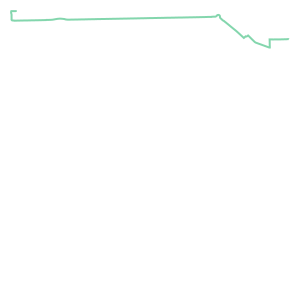

In [103]:
test_analysis.trip_vehicle_positions['9288619'].shape.geometry.iloc[0]